In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
import statsmodels.api as sm

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005
sns.set_theme(style="whitegrid", font_scale=1.1)


import movie_data_formatter as mdf
import movie_rating_popularity_year as mrpy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_movie_reviews_table(df)
movie_popular_data = mrpy.get_movie_aggregation(processed_data)

movie_popular_data.head()

new_movies = movie_popular_data[movie_popular_data['year_level'] == 'new']
old_movies = movie_popular_data[movie_popular_data['year_level'] == 'old']

# Question 2
Are movies that are newer rated differently than movies that are older? [Hint: Do a median split of year of 
release to contrast movies in terms of whether they are old or new] 


Both groups contained roughly 200 movies. 
The mean average rating for new movies was 2.66 (SD = 0.36) and for old movies 2.61 (SD = 0.34). 
Medians were similar (2.62 vs. 2.55), and spreads were comparable.

Descriptively, newer movies appear to be rated slightly higher on average, 
but the difference is small and requires statistical testing to confirm.


In [2]:
old_movies['average_rating'].describe()

count    197.000000
mean       2.605997
std        0.343650
min        1.929487
25%        2.339080
50%        2.550388
75%        2.820796
max        3.459979
Name: average_rating, dtype: float64

In [3]:
new_movies['average_rating'].describe()

count    203.000000
mean       2.662396
std        0.358479
min        1.915584
25%        2.376824
50%        2.618110
75%        2.964375
max        3.414207
Name: average_rating, dtype: float64

# Visualizations

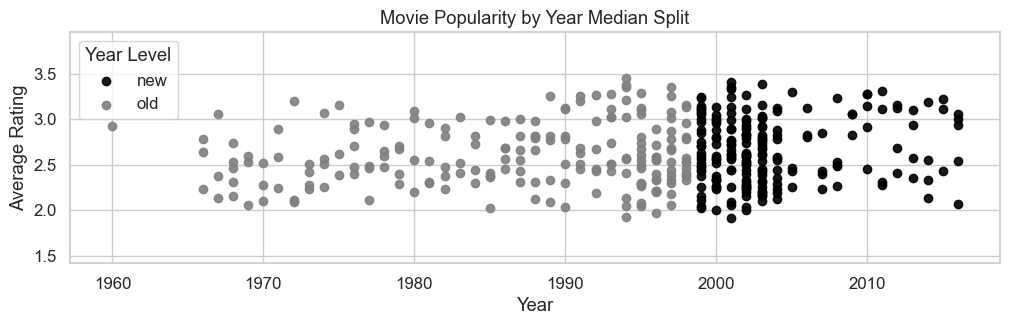

In [4]:
p = mrpy.plot_year_median_split(movie_popular_data, show=False)

# save to pdf
p.savefig("../figures/avg_rating_year.pdf", bbox_inches='tight')


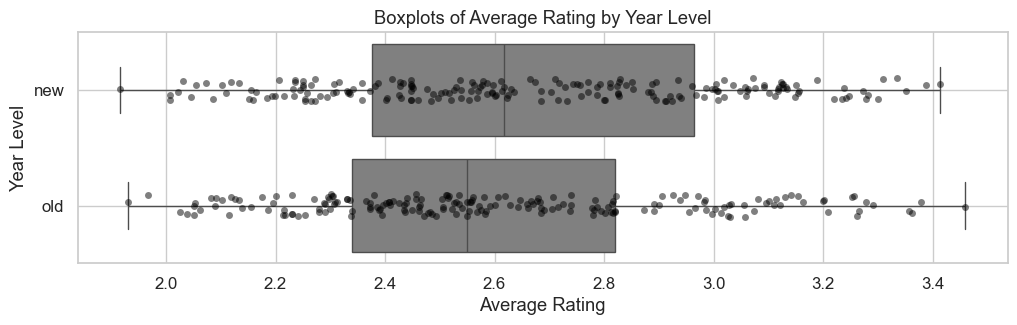

In [5]:
p = mrpy.plot_boxplots_year_level(movie_popular_data, show=False)

# save to pdf
p.savefig("../figures/box_plots_year_level.pdf", bbox_inches='tight')


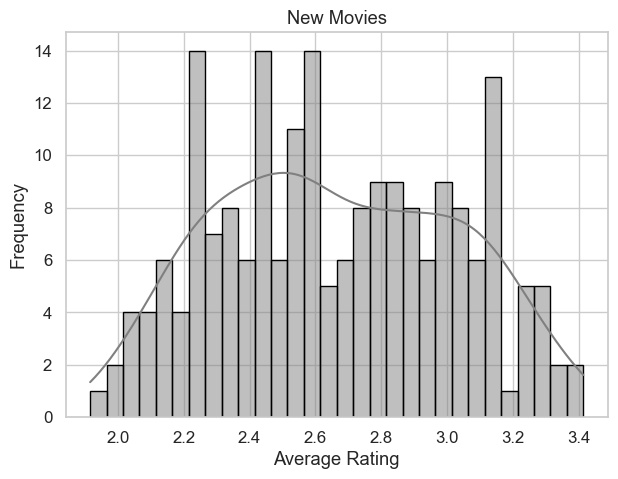

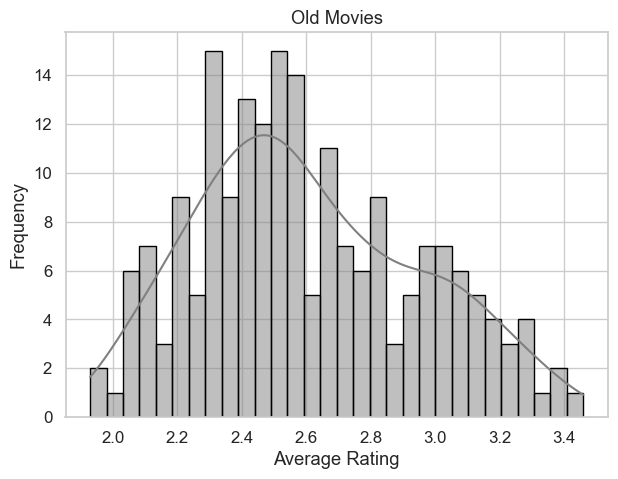

<module 'matplotlib.pyplot' from '/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [6]:
gf.plot_distrubtion(new_movies, "New Movies", y='average_rating')
gf.plot_distrubtion(old_movies, "Old Movies", y='average_rating')

/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


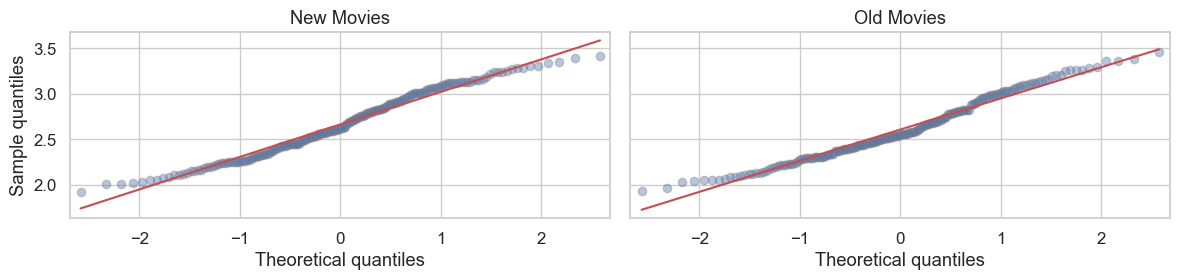

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=True)

x_new  = new_movies["average_rating"].astype(float).to_numpy()
x_old = old_movies["average_rating"].astype(float).to_numpy()
x_new  = x_new[np.isfinite(x_new)]
x_old = x_old[np.isfinite(x_old)]

# Use a scipy.stats distribution object
sm.ProbPlot(x_new,  dist=stats.norm).qqplot(ax=ax1, line="s", marker="o", markersize=6, alpha=0.4, color='black')
sm.ProbPlot(x_old, dist=stats.norm).qqplot(ax=ax2, line="s", marker="o", markersize=6, alpha=0.4, color='black')


# set the colors of the circles to grey with edgecolor black
ax1.get_lines()[0].set_color('lightgrey'); ax1.get_lines()[0].set_markeredgecolor('grey')
ax2.get_lines()[0].set_color('lightgrey'); ax2.get_lines()[0].set_markeredgecolor('grey')


ax1.set_title("New Movies");  ax2.set_title("Old Movies")
ax1.set_xlabel("Theoretical quantiles"); ax1.set_ylabel("Sample quantiles")
ax2.set_xlabel("Theoretical quantiles"); ax2.set_ylabel("")

fig.tight_layout()


# save as pdf -- no color
fig.savefig('../figures/qq_plot_year.pdf')

In [8]:
# variance for each group
# drop NA values first
variance_table = movie_popular_data.groupby('year_level')['average_rating'].agg(['count', 'mean', 'median', 'var', 'std']).reset_index()
print(variance_table)

ratio = variance_table.loc[variance_table['year_level'] == 'new', 'var'].values[0] / variance_table.loc[variance_table['year_level'] == 'old', 'var'].values[0]
print(f"Variance Ratio (New / Old): {ratio}")
print(f"Variance Ratio (Old / New): {1/ratio}")


  year_level  count      mean    median       var       std
0        new    203  2.662396  2.618110  0.128507  0.358479
1        old    197  2.605997  2.550388  0.118095  0.343650
Variance Ratio (New / Old): 1.088169062834046
Variance Ratio (Old / New): 0.9189748488121718


Observed mean difference (new - old): 0.0564
Bootstrap 95% CI for difference: [-0.0129, 0.1250]
Two-sided bootstrap p-value: 1.0000


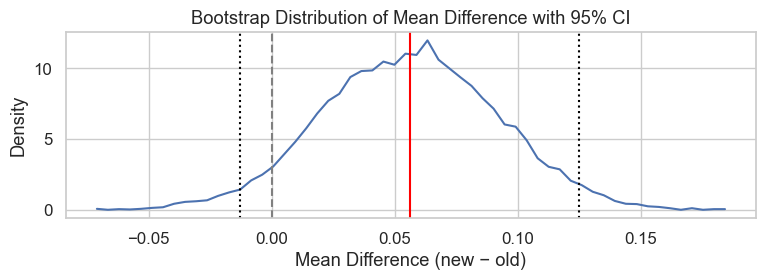

In [9]:
# did a bootstrap to estimate the 95% CI for the mean difference
# though I think it might be overkill since the t-test is robust to 
# normality with large enough samples

rng = np.random.default_rng(42)

old_r = old_movies['average_rating'].to_numpy()
new_r = new_movies['average_rating'].to_numpy()

B = 10000
n = min(len(new_r), len(old_r))     # balance the resamples
boot_old = np.empty(B)
boot_new = np.empty(B)
boot_delta = np.empty(B)

for b in range(B):
    old_s = rng.choice(old_r, size=n, replace=True)
    new_s = rng.choice(new_r, size=n, replace=True)
    boot_old[b] = old_s.mean()
    boot_new[b] = new_s.mean()
    boot_delta[b] = boot_new[b] - boot_old[b]

# Percentile CI for the mean difference
ci_lo, ci_hi = np.percentile(boot_delta, [2.5, 97.5])
delta_hat = new_r.mean() - old_r.mean()

# Two-sided bootstrap p-value for H0: delta = 0
# (proportion as or more extreme than |delta_hat|)
p_boot = (np.mean(np.abs(boot_delta) >= abs(delta_hat)) * 2).clip(0,1)

print(f"Observed mean difference (new - old): {delta_hat:.4f}")
print(f"Bootstrap 95% CI for difference: [{ci_lo:.4f}, {ci_hi:.4f}]")
print(f"Two-sided bootstrap p-value: {p_boot:.4f}")

plt.figure(figsize=(8,3))
counts, bin_edges = np.histogram(boot_delta, bins='auto', density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, counts)
plt.axvline(0, linestyle='--', color='gray')
plt.axvline(ci_lo, linestyle=':', color='black')
plt.axvline(ci_hi, linestyle=':', color='black')
plt.axvline(delta_hat, linestyle='-', color='red')
plt.xlabel('Mean Difference (new − old)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Mean Difference with 95% CI')
plt.tight_layout()

plt.savefig('../figures/bootstrap_mean_difference_year.pdf')


# Hypothesis Testing

Because we are not predicting whether newer movies are rated higher or lower than older movies, but only whether their ratings differ, we use a two-sided hypothesis test.


## Welch’s t-test
Since our groups are >= 30 each and not extremely skewed, we can also do the welch test.

### Set up
- H0 : mean of old = mean of new
- H1 : mean of old is not equal to mean of new 

In [10]:
t_stat, p_t = stats.ttest_ind(old_movies['average_rating'], new_movies['average_rating'], equal_var=False, alternative='two-sided')
gf.is_p_drop("Welch's t-test", t_stat, p_t, "mean", ALPHA)

Welch's t-test: -1.606, p-value: 0.1090
Fail to drop H0 --> No significant difference among means.


# Student's T-test
Use due to the lack of extreme variance. 

H0 : the mean between the new and old are equal 

H1: the mean between the new and old ratings are not equal

In [11]:

stat, p = stats.ttest_ind(new_movies['average_rating'], old_movies['average_rating'], equal_var=True)
gf.is_p_drop("Student's t-test", stat, p, "mean", ALPHA)

n1 = len(new_movies)
n2 = len(old_movies)
gf.two_sample_ttest_ind_df(n1, n2)

Student's t-test: 1.605, p-value: 0.1092
Fail to drop H0 --> No significant difference among means.


398

# Conclusion 

Both the Welch’s t-test and the Mann–Whitney U test agree that there is no statistically significant difference in the average ratings between old and new movies. This suggests that, on average, movies released more recently are rated similarly to older movies. While newer movies show a slightly higher mean rating descriptively, the difference is not large enough to be statistically meaningful.